**By: Ahmed Abdulghany**

# Chapter 8. Dimensionality Reduction

**Why Dimensionality Reduction Matters**

**The Problem: The Curse of Dimensionality**

    What it is: As features increase, the data becomes sparse. This makes models less effective and training slower.

    Example: In a dataset with 10,000 features, the distance between data points becomes less meaningful. Similar points may appear distant due to noise.

    Result: Overfitting, increased computation, and poor generalization.

**When to Use Dimensionality Reduction**

**Benefits:**

    Speed up training

    Simplify models

    Improve visualization (e.g., plotting in 2D or 3D)

    Sometimes improves accuracy by removing noise

**Downsides:**

    Information loss (just like JPEG compression)

    More complex pipeline

    Doesn’t always improve model accuracy

>Tip: Always try training on the original data first. Use dimensionality reduction **only if needed**.

Example: MNIST Dataset

    Observation: Edge pixels are usually white (i.e., zero value)

    Action: Remove them — minimal impact on performance

    Also: Merge neighboring pixels by averaging — reduces features without losing key patterns

**Two Main Techniques**

1. Projection Methods

    Project data from high-dimensional space onto a lower-dimensional subspace

    Example: Principal Component Analysis (PCA)

2. Manifold Learning

    Assumes data lies on a curved lower-dimensional surface (manifold)

    Example: Locally Linear Embedding (LLE)

**Techniques in This Chapter**

1. PCA (Principal Component Analysis)

    Fast, linear, widely used

2. Random Projection

    Fast and simple, but can be less accurate

3. LLE (Locally Linear Embedding)

    Nonlinear, useful for complex data shapes
----

**Dimensionality reduction is a powerful tool, but not a silver bullet. Use it when:**

    You face slow training

    You need to visualize your data

    Your dataset has lots of irrelevant/noisy features

But always compare model performance **with and without** reduction.

# The Curse of Dimensionality

**The Problem**

**As the number of dimensions (features) increases:**
- Data becomes sparse — points are spread thin across the space.
- Distances become meaningless — everything is far apart.
- Models overfit easily — because patterns become harder to learn.
- More data is required — and not just a bit more… exponentially more.

**How Distance Behaves in High Dimensions**
| Dimensionality       | Shape                   | Avg Distance Between Points | Probability Close to Border |
| -------------------- | ----------------------- | --------------------------- | --------------------------- |
| 2D (unit square)     | Flat square (1x1)       | ≈ 0.52                      | ≈ 0.4%                      |
| 3D (unit cube)       | Volume (1x1x1)          | ≈ 0.66                      | Small                       |
| 10,000D hypercube    | Impossible to visualize | ≈ Close to 81.65 (√10000)   | > 99.999999%                |
| 1,000,000D hypercube | Abstract hypervolume    | ≈ 1000 (√1,000,000)         | Essentially 100%            |

> In high dimensions, almost all points are near the edges of the hypercube. That’s completely unintuitive.

**Example:** Imagine a point in a 10,000-dimensional space. It's almost certainly very far from the center — and also far from any other point. That breaks down clustering, similarity, and distance-based reasoning.

**Why This Is Bad for Machine Learning**
- **Sparsity:** Data is too spread out to capture meaningful relationships.
- **Extrapolation risk:** Predictions are made in parts of space the model barely knows.
- **Overfitting:** Models latch onto noise, not signal.
- **Data requirement explodes:** You’d need more data than atoms in the universe to get decent coverage at 100 dimensions with 0.1 proximity!

**What Can You Do?**

**Strategies to Tackle the Curse:**
1. Feature Selection

    Drop irrelevant or redundant features.

    Use correlation analysis or mutual information.

2. Dimensionality Reduction Techniques

    PCA: Linear projection based on variance.

    LLE / t-SNE / UMAP: Nonlinear techniques that preserve structure.

    Autoencoders: Deep learning-based compression.

3. Regularization

    Penalizes model complexity to reduce overfitting (e.g., L1, L2 norms).

4. More Data

    Helps — but not enough in high dimensions unless you reduce dimensionality too.

so thatt The curse of dimensionality isn't just a mathematical curiosity. It's a **real threat** to machine learning models — especially with high-dimensional datasets like text, images, or genomics. You should never ignore it. Use tools like PCA, t-SNE, or feature selection to reduce your problem to a more manageable size.

# Main Approaches for Dimensionality Reduction

## Projection (Linear Approach)

Projecting data onto a lower-dimensional flat subspace (a hyperplane). Assumes that your data lives close to a linear surface in high-dimensional space.

**Real-world Insight:**

    Many features are constant or correlated (e.g., MNIST's border pixels).

    Training data may lie close to a lower-dimensional "slice" of space.

**Example:**

    A 3D dataset shaped like a sheet of paper inside a cube.

    We project all points onto that sheet → now it's 2D.

    New axes (z₁, z₂) represent the projected coordinates.

**Use Projection When:**

    Data is linearly correlated

    You want speed and interpretability

    You're okay with information loss from flattening

**Key Methods:**

    PCA (Principal Component Analysis)

    Random Projection

    Linear Discriminant Analysis (LDA)

In [3]:
# extra code

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

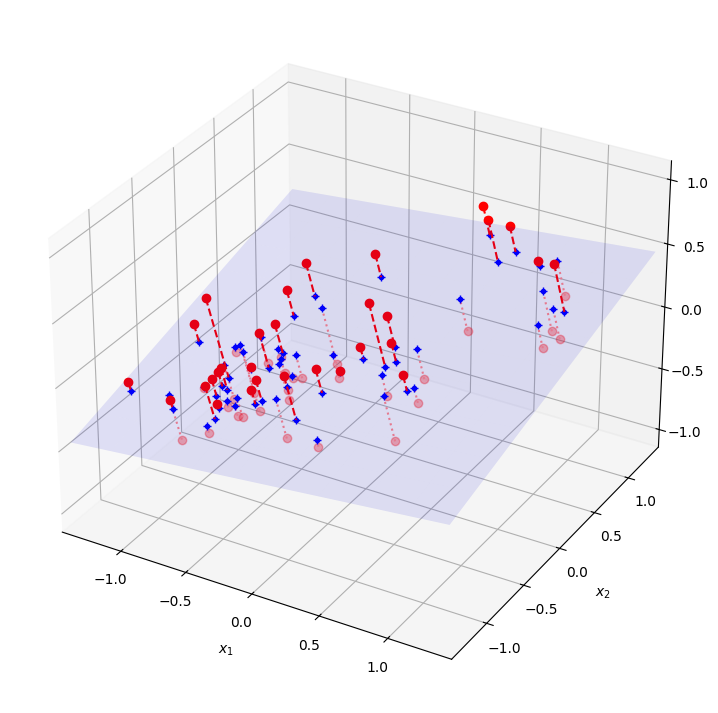

In [4]:
# Figure 8–2

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

plt.show()

- Reduces your dataset `X` (must be 3D) to 2D using PCA.
- Then maps the 2D projection back into the original 3D space.
- Performs **SVD** to get principal directions.
- Uses those to define the projection plane.
- Creates a grid over `x₁` and `x₂`
- Calculates the height (z) of the plane using PCA components.
- Separates points that lie above or below the plane to plot them differently.

- Plotting in 3D

    Red dots (`ro`) show original 3D points.

    Blue dots (`b+`, `b.`) show their projections on the plane.

    Dashed lines connect original points to their projections — showing the perpendicular projection.

**Make Sure:**
- You define `X` (your 3D dataset) and `m = len(X)` before this script.
- `X` should be a NumPy array with shape `(m, 3)`

----

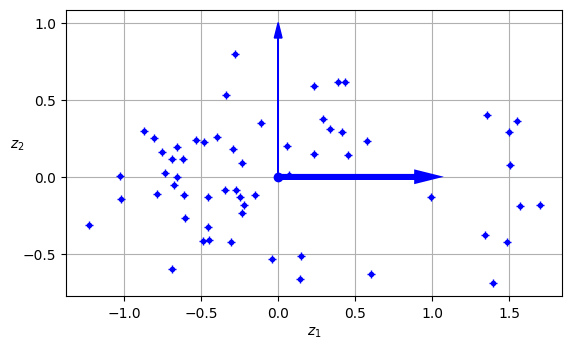

In [5]:
# Figure 8–3

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=4)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1)
ax.set_xlabel("$z_1$")
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_ylabel("$z_2$", rotation=0)
ax.set_axisbelow(True)
ax.grid(True)


## Manifold Learning (Nonlinear Approach)

Assumes that the data lies on a nonlinear, curved surface (manifold) within a higher-dimensional space. Tries to unroll or flatten that surface while preserving the structure.

**Swiss Roll Example:**

    A 2D sheet rolled into 3D space (like a cinnamon roll).

    Projecting onto a flat plane (like dropping x₃) would squash it — layers would overlap incorrectly.

    Manifold learning tries to "unroll" it instead, revealing the true 2D structure.

**Manifold Assumption:**

Most real-world high-dimensional datasets lie on lower-dimensional manifolds due to structure and constraints:

    Handwritten digits follow specific patterns.

    Human poses follow biological constraints.

    Sensor data often comes from low-degree-of-freedom systems.

**But a Caution:**

    Sometimes, the decision boundary for classification is simpler in high dimensions (e.g., a flat plane) than after unrolling.

    Manifold learning doesn't always improve your task performance — it depends on the shape and complexity of your data.

**Use Manifold Learning When:**

    Data has nonlinear relationships

    Visualization or structure discovery is key

    You can accept higher computation costs

**Key Methods:**

    t-SNE

    UMAP

    Isomap

    LLE (Locally Linear Embedding)

In [6]:
from sklearn.datasets import make_swiss_roll

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

`X_swiss`: 3D coordinates shaped like a rolled-up sheet.

`t`: "Unrolling" parameter — it helps color the points to show their true 2D structure.

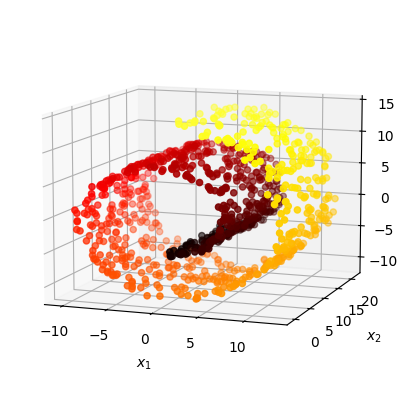

In [7]:
# Figure 8–4

from matplotlib.colors import ListedColormap

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)  # camera angle
set_xyz_axes(ax, axes)  # labels and limits

plt.show()

- Points are color-coded by `t` to visualize the unrolling structure.
- The camera angle is chosen to clearly show the "roll" shape.
- `set_xyz_axes` must be defined earlier (you already have it in your PCA figure).

What's the Swiss Roll?

    It's a 2D manifold embedded in 3D space.

    It looks complex in 3D but is actually simple if you could unroll it.

    This dataset is used to test nonlinear dimensionality reduction methods like:

        t-SNE

        UMAP

        Isomap

        Locally Linear Embedding (LLE)

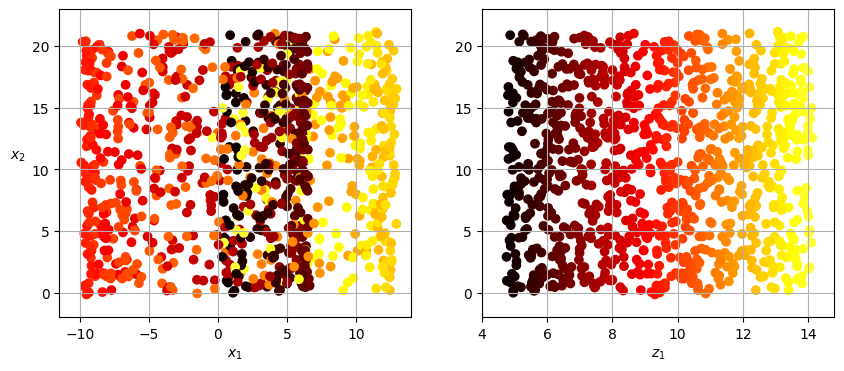

In [8]:
# Figure 8–5

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.scatter(X_swiss[:, 0], X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", labelpad=10, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis([4, 14.8, axes[2], axes[3]])
plt.xlabel("$z_1$")
plt.grid(True)

plt.show()

| Aspect               | Left Plot (`x₁`, `x₂`) | Right Plot (`t`, `x₂`)    |
| -------------------- | ---------------------- | ------------------------- |
| Method               | Linear projection      | Manifold coordinate       |
| Structure preserved? | No (layers overlap)  |   Yes (unrolled properly) |
| Real-world analogy   | Squashed map           | Properly flattened map    |


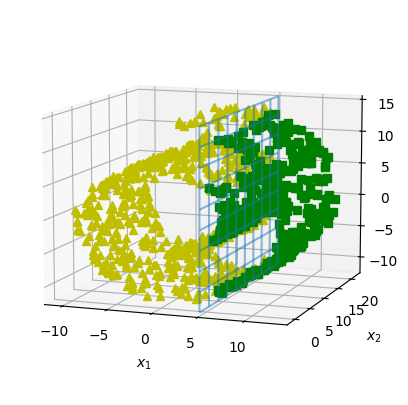

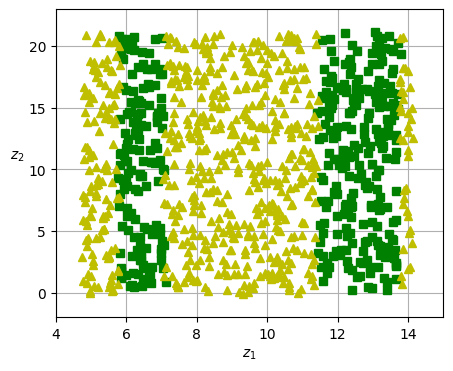

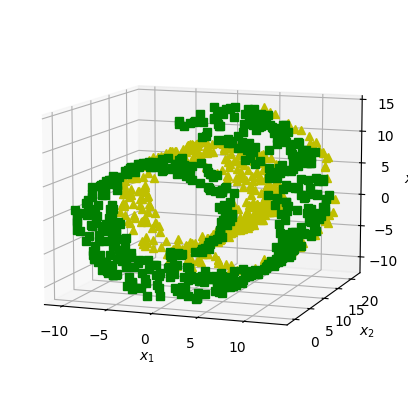

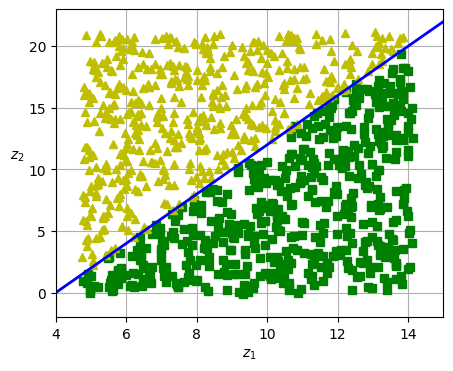

In [9]:
# Figure 8–6
    
axes = [-11.5, 14, -2, 23, -12, 15]
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

positive_class = X_swiss[:, 0] > 5
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
set_xyz_axes(ax, axes)

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)

plt.show()

positive_class = 2 * (t[:] - 4) > X_swiss[:, 1]
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x_1$", rotation=0)
ax.set_ylabel("$x_2$", rotation=0)
ax.set_zlabel("$x_3$", rotation=0)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.plot([4, 15], [0, 22], "b-", linewidth=2)
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)

plt.show()

----
| Aspect               | Projection                 | Manifold Learning                 |
| -------------------- | -------------------------- | --------------------------------- |
| Assumes              | Linear subspace            | Curved manifold                   |
| Key methods          | PCA, Random Projection     | t-SNE, LLE, UMAP, Isomap          |
| Computation          | Fast                       | Slower, more complex              |
| Use cases            | Preprocessing, compression | Visualization, structure learning |
| Handles nonlinearity | No                         | Yes                               |
| Interpretation       | Easy (linear components)   | Hard (nonlinear embeddings)       |
| Downside             | Info loss from flattening  | May distort decision boundaries   |

---
If you're working with **structured or image-like data**, start with **PCA** — it's fast, effective, and interpretable.

But if you're doing **exploratory analysis**, clustering, or working with nonlinear or highly entangled data (like language or audio), consider **manifold learning** techniques like **t-SNE or UMAP**.

>Always test both if your dataset is complex — sometimes lower dimensions help, sometimes they distort.

# PCA
It is ne of the most powerful and widely used techniques in machine learning for dimensionality reduction

It finds a lower-dimensional **linear subspace** (a hyperplane) that captures the **maximum variance** in your data, then projects the data onto it.

## Preserving the Variance

**Why Preserving Variance Matters**

**Imagine a Simple 2D Dataset:**

    Think of points scattered in a cloud on a 2D plane.

    You want to reduce it to 1D by projecting the points onto a line (a "1D hyperplane").

There are many lines you could project onto..

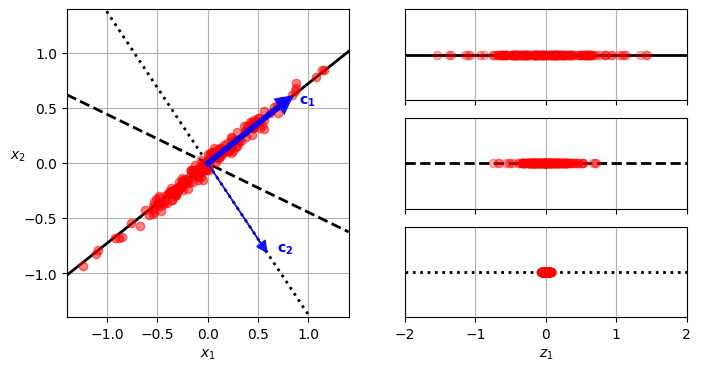

In [10]:
# Figure 8–7

angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X_line = np.random.randn(m, 2) / 10
X_line = X_line @ np.array([[stretch, 0], [0, 1]])  # stretch
X_line = X_line @ [[np.cos(angle), np.sin(angle)],
                   [np.sin(angle), np.cos(angle)]]  # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

X_proj1 = X_line @ u1.reshape(-1, 1)
X_proj2 = X_line @ u2.reshape(-1, 1)
X_proj3 = X_line @ u3.reshape(-1, 1)

plt.figure(figsize=(8, 4))
plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:",
         linewidth=2)
plt.plot(X_line[:, 0], X_line[:, 1], "ro", alpha=0.5)
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=4, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=1, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", color="blue")
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", color="blue")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.grid()

plt.subplot2grid((3, 2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=2)
plt.plot(X_proj1[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=2)
plt.plot(X_proj2[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$")
plt.grid()

plt.show()

| Projection Line | Result on the Right         | Info Preserved |
| --------------- | --------------------------- | -------------- |
| **Solid Line**  | Long spread of data (top)   | **Maximum**  |
| Dashed Line     | Medium spread (middle)      | Medium       |
| Dotted Line     | Compressed cluster (bottom) | Low          |

**Why This Line Is Best**

There are two justifications for choosing the direction of maximum variance:

1. Information Preservation

    Variance = how much the data spreads in that direction.

    More variance → more "signal", less "noise".

    So the principal component retains more information from the original data.

2. Minimal Reconstruction Error

    When you project data to 1D and then reconstruct it back to 2D, there's loss.

    The best direction (PCA's first principal component) minimizes the mean squared error between the original and reconstructed data.

**So PCA:**

    Maximizes variance and

    Minimizes projection error.

This makes it both intuitive and mathematically optimal for linear compression.

> If you ever wonder why PCA works, "variance = information" is your north star.

## Principal Components

**What Are Principal Components (PCs)?**

A Principal Component (PC) is:
1. A unit vector (direction in feature space)
2. Along which the data shows maximum variance
3. And is orthogonal (perpendicular) to all previous PCs

**In 2D:**
1. First PC: The direction with most spread in the data (solid line in Figure 8-7).
2. Second PC: The only remaining orthogonal direction, captures leftover variance (dotted line).

**In higher dimensions:**

PCA finds:

    PC1: Most variance

    PC2: Orthogonal to PC1, second most variance

    PC3: Orthogonal to PC1 and PC2, third most variance
    ... and so on, up to n PCs for n features.

Each PC captures less variance than the one before (unless the data is perfectly symmetric).

-----

**PCA and SVD (Singular Value Decomposition)**

You use SVD to compute PCs because it's numerically stable and efficient:

**SVD Decomposes the Centered Data:**

Xcentered​=UΣV^T

    V^T: contains principal components as rows

    U: contains projections (scores)

    Σ: singular values (related to variance explained)

In [11]:
import numpy as np

# X = [...]  # the small 3D dataset was created earlier in this notebook
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

Note: in principle, the SVD factorization algorithm returns three matrices, **U**, **Σ** and **V**, such that **X** = **UΣV**<sup>⊺</sup>, where **U** is an _m_ × _m_ matrix, **Σ** is an _m_ × _n_ matrix, and **V** is an _n_ × _n_ matrix. But the `svd()` function returns **U**, **s** and **V**<sup>⊺</sup> instead. **s** is the vector containing all the values on the main diagonal of the top _n_ rows of **Σ**. Since **Σ** is full of zeros elsewhere, your can easily reconstruct it from **s**, like this:

In [12]:
# extra code – shows how to construct Σ from s
m, n = X.shape
Σ = np.zeros_like(X_centered)
Σ[:n, :n] = np.diag(s)
assert np.allclose(X_centered, U @ Σ @ Vt)

**Stability Warning**

**PCA’s Direction Can Flip:**

    The sign of each PC is arbitrary. c1 might point right one time, and left the next — it's still the same axis.

    If two PCs explain similar variance, they may even swap places with small changes to the data.

But the subspace they define remains stable. That’s why PCA is robust for dimensionality reduction — even if individual directions jitter.

| Concept             | Description                                            |
| ------------------- | ------------------------------------------------------ |
| Principal Component | Unit vector in direction of maximum variance           |
| Orthogonal          | Each PC is perpendicular to previous ones              |
| PCA Goal            | Find top `d` PCs to project data and preserve variance |
| SVD Output          | `Vt` contains the PCs                                  |
| Centering           | Essential step before applying PCA                     |
| Sign Ambiguity      | Direction may flip; axis remains the same              |

so that understanding principal components is essential to mastering PCA — and SVD gives you a powerful tool to compute them. Always remember to center your data, and don’t worry if the signs flip — the math still works perfectly. This is where linear algebra truly shines in data science.

## Projecting Down to d Dimensions

how to actually reduce dimensionality using PCA by projecting your data onto the top `d` principal components. This is where PCA moves from theory to practice

**Goal: Project Down to `d` Dimensions**

Once you've found the principal components (PCs), you can project your dataset onto the hyperplane spanned by the top `d` components.

This means:

    Keep only the directions with the most variance

    Discard directions with little variance (often noise)

    Result: a compressed version of the data that keeps the most important structure

**Mathematics Behind It**

Let:

- `X_centered` = your dataset centered around the origin
- `Vt` = matrix of principal components (from SVD: `X_centered = U Σ Vt`)
- `W_d` = first `d` columns of `V` (or rows of `Vt`)

Then the projection is:
        Xd-proj​=Xcentered​⋅Wd​

In [13]:
import numpy as np

# Step 1: Center the data
X_centered = X - X.mean(axis=0)

# Step 2: Compute SVD
U, s, Vt = np.linalg.svd(X_centered)

# Step 3: Take the first d principal components (e.g., d = 2)
W2 = Vt[:2].T  # shape: (n_features, 2)

# Step 4: Project data onto this 2D plane
X2D = X_centered @ W2

`X2D` is now your 2D representation of the original dataset.

If you want `d=3`, just change `Vt[:2].T` to `Vt[:3].T`

>    Imagine a cloud of 3D points (like in Figure 8–2). PCA fits a flat plane (2D) through the data cloud that captures the most variance. Then it drops every point onto that plane — this is the projection.

>The result looks like a flattened version of the original dataset, preserving as much of its shape as possible.


## Using Scikit-Learn

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)       # Keep 2 principal components
X2D = pca.fit_transform(X)      # Fit PCA and project the data

What This Does:
- Centers the data for you (no need to subtract the mean manually)
- Computes SVD internally to find the principal components
- Projects the data onto the top 2 components

**Comparison to Manual SVD**

In manual SVD:
- You center the data → `X_centered`
- Use `np.linalg.svd(X_centered)` to get `U`, `s`, `Vt`
- Use `Vt[:2].T` as `W` to project data

In Scikit-learn:
- `pca.components_` = top `d` principal components (same as `Vt[:d]`)
- You don’t need to do matrix multiplication manually — `fit_transform()` handles it.

In [15]:
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

**Why This Is Useful**
- Compress data for faster training
- Visualize in 2D or 3D
- De-noise high-dimensional data
- Preprocess for clustering or classification

>This final step is what makes PCA powerful: it gives you a clear, mathematically optimal way to compress your data with minimal loss. Once you’ve mastered projection, you can apply PCA confidently across datasets for visualization, noise reduction, or speeding up models.

So that, Using `Scikit-learn.PCA` is the fastest and safest way to apply PCA in real projects. It handles centering, projection, and even gives you variance metrics for free. You should use this unless you’re doing educational demos or need full manual control for algorithm development.

## Explained Variance Ratio

The `explained_variance_ratio_` tells you:

    How much of the total variance is captured by each principal component (PC)

    It helps you decide how many PCs to keep

    Great for checking if 2D or 3D captures enough structure

In [16]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

**Interpretation:**
- PC1 captures ~75.8% of the dataset’s variance
- PC2 captures ~15.2%
- Together, the first two components explain ~91% of the variance
- That leaves only ~9% for the third PC, so it's probably safe to discard it

**Why This Matters**
- Helps you choose `n_components` automatically
- Tells you if dimensionality reduction is losing important information
- Useful for plotting cumulative variance curves (elbow method)

In [17]:
1 - pca.explained_variance_ratio_.sum()  # extra code

0.09028309326742034

>The explained variance ratio is the key diagnostic in PCA. Always check it after fitting — it tells you how much useful structure you're keeping and when it's safe to discard dimensions. Use it with a cumulative plot for the clearest insight. It's simple, but incredibly powerful

## Choosing the Right Number of Dimensions

This decision **directly affects model performance**, training time, and interpretability. Let's break it down into actionable insights with practical Python code examples

**Why Not Just Pick a Number?**

Choosing the number of principal components (`n_components`) arbitrarily is risky:

    You may lose important information if too low.

    You may retain noise and slow down training if too high.

**Recommended Strategies**

1. Preserve a Target Variance (e.g., 95%)

The most common and sensible method:

    Choose the smallest number of components that together explain at least 95% of the variance.

In [18]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)

# Cumulative sum of explained variance
cumsum = np.cumsum(pca.explained_variance_ratio_)

# Find smallest d such that at least 95% variance is retained
d = np.argmax(cumsum >= 0.95) + 1

Note: I added `parser="auto"` when calling `fetch_openml()` to avoid a warning about the fact that the default value for that parameter will change in the future (it's irrelevant in this case). Please see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html) for more details.

In [19]:
d

154

2. Let PCA Handle It Automatically

Instead of finding `d` manually, just pass the variance threshold:

In [20]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [21]:
pca.n_components_

154

In [22]:
pca.explained_variance_ratio_.sum() 

0.9501960192613033

3. Visualize Explained Variance – Elbow Method

Plot the cumulative variance curve to visually choose the "elbow point" — where adding more components yields diminishing returns.

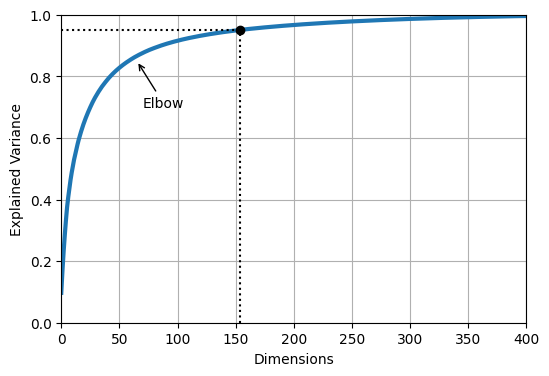

In [23]:
# Figure 8–8

plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)

plt.show()

4. Hyperparameter Tuning with Pipelines

If you’re using PCA as part of a supervised ML pipeline, tune n_components just like any other hyperparameter:

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(
    PCA(random_state=42),
    RandomForestClassifier(random_state=42)
)

param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}

rnd_search = RandomizedSearchCV(
    clf, param_distrib, 
    n_iter=10, 
    cv=3,
    random_state=42
)

rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [25]:
rnd_search.best_params_

{'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23}

Surprising? Maybe — but it shows how effective dimensionality reduction can be when paired with powerful models like Random Forests. A linear model like `SGDClassifier` would likely require more components (around ~70).

| Method                   | Description                      | Best Use Case                     |
| ------------------------ | -------------------------------- | --------------------------------- |
| `n_components = d`       | Manual dimension selection       | Simple use cases, prior knowledge |
| `n_components = 0.95`    | Auto-select based on variance    | General-purpose feature reduction |
| Plot cumulative variance | Use elbow to choose `d` visually | Visual analytics                  |
| `RandomizedSearchCV`     | Tune PCA + model together        | Model optimization                |


Don’t guess.
Use the **explained variance curve** or **automated thresholds** to pick `n_components`. Then refine further with hyperparameter tuning if PCA is part of a machine learning pipeline. It's one of the most impactful yet often overlooked steps in building a clean, efficient model pipeline

In [26]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import numpy as np

clf = make_pipeline(PCA(random_state=42), SGDClassifier())
param_grid = {"pca__n_components": np.arange(10, 80)}
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train[:1000], y_train[:1000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])})

- You're tuning `pca__n_components` between 10 and 79
- You're using SGDClassifier, a linear model
- You run cross-validation (CV=3) on the first 1,000 MNIST samples
- You identify the best number of components using validation accuracy

In [27]:
grid_search.best_params_

{'pca__n_components': 67}

This means:

To get the best performance with SGDClassifier on your data, 67 principal components is optimal (on this sample size).

**Why 67 Components?**

    PCA orders components by decreasing variance

    67 PCs retain enough structure for a linear model like SGDClassifier to separate the digits effectively

    Going higher might not help (adds noise), and lower loses critical variance

This is much higher than with a Random Forest, which only needed 23 components earlier — that's because:

    SGDClassifier is linear: it needs more features to find a good decision boundary

    Random Forest is nonlinear and ensemble-based, so it can do more with less

| Step                        | Tip                                                                  |
| --------------------------- | -------------------------------------------------------------------- |
| Use PCA with pipeline       | Avoids data leakage and simplifies preprocessing                     |
| Use `GridSearchCV`          | Systematically finds the best number of dimensions                   |
| Use `SGDClassifier`         | Good baseline linear classifier for large sparse datasets like MNIST |
| Limit data (e.g. `[:1000]`) | Great for quick experiments — scale up when satisfied                |


## PCA for Compression

A super practical use of dimensionality reduction for speed, storage, and sometimes even privacy. 

**Goal: Reduce Dimensionality for Compression**

**Original:**

    784 features (28×28 pixels per image)

**After PCA with 95% variance retained:**

    Reduced to 154 components

    That's ~20% of the original size

    Only 5% of the variance is lost — a great trade-off!

**Why It Works**

    PCA projects your data to a lower-dimensional space while retaining the structure that contributes most to variance (i.e., the "signal").

    By keeping just the top principal components, we discard noise and redundancy.

**How to Decompress the Data**

In [28]:
pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train, y_train)

In [29]:
X_recovered = pca.inverse_transform(X_reduced)

- `X_reduced`: is the compressed data in 154 dimensions
- `pca.inverse_transform(...)`: projects it back to 784 dimensions
- Output: an approximation of the original data — slightly blurred but mostly intact

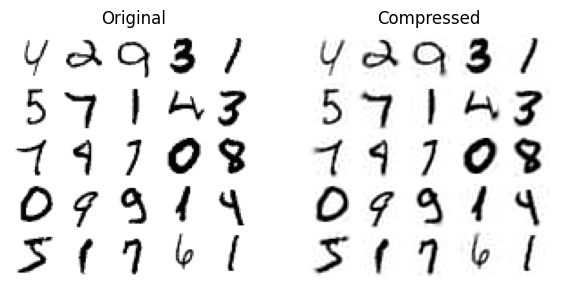

In [30]:
# Figure 8–9

plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

Result:

    Top row: original digits

    Bottom row: compressed and reconstructed

    Most digits are still clear, though slightly blurrier — proof that compression worked

**Math Behind the Inverse Transformation**

PCA projection:
        Xreduced​=Xcentered​⋅Wd​

Inverse (reconstruction):
        Xrecovered​=Xreduced​⋅Wd⊤​

Where:
- Wd​ contains the top `d` principal components as columns
- The reconstruction approximates the original data

| Step              | Function                       |
| ----------------- | ------------------------------ |
| Reduce dimensions | `PCA(n_components=0.95)`       |
| Compress          | `fit_transform(X)`             |
| Reconstruct       | `inverse_transform(X_reduced)` |
| Measure error     | `mean_squared_error(X, X_rec)` |

> PCA for compression is one of the simplest and most effective ways to shrink datasets without losing much utility. It's great not only for speeding up training but also for compressing data for storage or preprocessing steps. When ~80% of your original features can be discarded without much loss — that’s a huge win

## Randomized PCA
A fast approximation of standard PCA that’s ideal for large datasets like MNIST or any high-dimensional data

**What Is Randomized PCA?**

Randomized PCA is a stochastic approximation method that:
- Finds the top `d` principal components quickly
- Is much faster than full SVD when `d << n`
- Still captures almost the same variance (especially useful for compression or preprocessing)


| Method         | Time Complexity    | Best For                        |
| -------------- | ------------------ | ------------------------------- |
| Full SVD       | $O(mn^2) + O(n^3)$ | Small to medium datasets        |
| Randomized PCA | $O(md^2) + O(d^3)$ | Large `m` and/or `n`, small `d` |

Where:

    m: number of samples

    n: number of features

    d: number of components (desired dimensions)

So if d is much smaller than n, randomized PCA is significantly faster.

In [31]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

`n_components=154`: keep 95% variance in MNIST (as seen before)

`svd_solver="randomized"`: uses the faster randomized algorithm

`random_state=42`: ensures reproducibility (important because it’s stochastic)

> TIP: Scikit-Learn Automatically Chooses the Solver

In [32]:
pca = PCA(n_components=154)  # No solver specified

Internally, `svd_solver='auto'` is used by default.

Scikit-Learn switches to `"randomized"` when:

- `max(m, n) > 500`
- `n_components < 0.8 * min(m, n)`

So you don’t need to set it manually unless:
- You want deterministic behavior
- You want to force full SVD with `svd_solver="full"` for exact PCs


**Should You Use Randomized PCA?**

**Use it when:**

    You're working with large datasets

    You're okay with minor approximation error

    You want faster computation, especially for real-time or repeated model training

**Avoid it when:**

- You need very precise components (e.g., scientific modeling)
- `n_components` is close to `n` (full SVD might be better)

**Quick Benchmark (Example)**

On a standard laptop:
- Full SVD on MNIST (784 features) → takes ~5–10 seconds
- Randomized PCA with `n_components=154` → takes <1 second

> Randomized PCA is a **must-use tool** when you're dealing with large datasets or need fast preprocessing. Unless you're doing scientific analysis that requires exact precision, the tiny accuracy trade-off is worth the speed boost. For most practical ML pipelines — especially in production — this is the PCA mode I’d recommend.

## Incremental PCA
A crucial tool when working with large datasets that don’t fit into memory or need to be processed on the fly (online learning). 


**What Is Incremental PCA?**

**Traditional PCA:**

    Requires entire dataset in memory

    Uses full SVD or randomized SVD

    Not suitable for very large datasets

**Incremental PCA:**

    Processes data in mini-batches

    Fits data incrementally using `.partial_fit()`

    Can be used in online or streaming scenarios

    Lower memory footprint

In [33]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

Use this when:

    Your dataset is too large for RAM

    You're loading from disk or stream

    You want batch-wise training (common in ML pipelines)

**Using NumPy's `memmap` class – a memory-map to an array stored in a binary file on disk.**

>`np.memmap` lets you handle datasets stored on disk as if they were NumPy arrays — without loading everything into memory.

Let's create the `memmap` instance, copy the MNIST training set into it, and call `flush()` which ensures that any data still in cache is saved to disk. This would typically be done by a first program:

In [34]:
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mmap[:] = X_train  # could be a loop instead, saving the data chunk by chunk
X_mmap.flush()

Next, another program would load the data and use it for training:

In [35]:
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

This avoids writing `partial_fit()` loops manually, but still fits incrementally under the hood.

**Important Warning:**

> np.memmap only saves raw data, so you must specify:

`dtype`

`shape`

Otherwise, you'll get a broken or 1D array

**When Not to Use PCA**

Even IPCA can become too slow or memory-intensive when:
- `d` (number of target dimensions) is very large
- You have very high-dimensional input (e.g., gene expression, big NLP embeddings)

**Consider Random Projection Instead:**

Random Projection:

    Is faster

    Uses random matrices to approximate distances

    Lower computational cost than PCA

In [36]:
from sklearn.random_projection import GaussianRandomProjection

rp = GaussianRandomProjection(n_components=154, random_state=42)
X_reduced = rp.fit_transform(X_train)


| Method                | Handles Large Data? | Streaming / Online? | Accuracy      | Speed     |
| --------------------- | ------------------- | ------------------- | ------------- | --------- |
| **PCA (full)**        | No                  | No                | High        | Slow    |
| **Randomized PCA**    | Yes (medium)        | No                | Good        | Fast    |
| **Incremental PCA**   | Yes (large)         | Yes               | Good        | Slower |
| **Random Projection** | Yes (very large)    | Yes               | Approximate | Fastest |


> Incremental PCA is a must-know technique for working with datasets that exceed RAM, especially in real-world settings like time series, streaming logs, or massive image sets. Combine it with `memmap` for true disk-based processing. And if PCA still slows you down? Random Projection is a solid fallback.

## Random Projection

Random Projection is a technique to reduce the dimensionality of data using a random linear projection. The key idea: even with randomness, distances between data points are largely preserved. This is thanks to the Johnson-Lindenstrauss Lemma, which proves that a small number of dimensions can approximately maintain distances with high probability.

The Math Behind It

If you have:

    m: number of data points (e.g., 5,000)

    n: number of features (e.g., 20,000)

    ε: tolerance (e.g., 0.1 for 10% distortion)

You can compute the minimum dimension dd needed to preserve distances as:
d≥4⋅log⁡(m)/((0.5ε^2)−(1/3ε^3))

**Warning**: this sections will use close to 2.5 GB of RAM. If your computer runs out of memory, just reduce _m_ and _n_:

In [37]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

m, ε = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=ε)
d

7300

Example result: d = 7300, which is a huge reduction from 20,000 features!

In [38]:
# show the equation computed by johnson_lindenstrauss_min_dim
d = int(4 * np.log(m) / (ε ** 2 / 2 - ε ** 3 / 3))
d

7300

In [39]:
n = 20_000
np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d)  # std dev = square root of variance

X = np.random.randn(m, n)  # generate a fake dataset
X_reduced = X @ P.T

**With Scikit-Learn (Easier)**

In [40]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=ε, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)  # same result as above

**Warning**, the following cell may take several minutes to run:

In [41]:
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

**Sparse Alternative: Better for Memory**
    
    Use `SparseRandomProjection` for better performance:

In [42]:
#performance comparison between Gaussian and Sparse RP

from sklearn.random_projection import SparseRandomProjection

print("GaussianRandomProjection fit")
%timeit GaussianRandomProjection(random_state=42).fit(X)
print("SparseRandomProjection fit")
%timeit SparseRandomProjection(random_state=42).fit(X)

gaussian_rnd_proj = GaussianRandomProjection(random_state=42).fit(X)
sparse_rnd_proj = SparseRandomProjection(random_state=42).fit(X)
print("GaussianRandomProjection transform")
%timeit gaussian_rnd_proj.transform(X)
print("SparseRandomProjection transform")
%timeit sparse_rnd_proj.transform(X)

GaussianRandomProjection fit
2.79 s ± 35.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection fit
1.96 s ± 64.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GaussianRandomProjection transform
8.66 s ± 465 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection transform
3.02 s ± 15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Performance Results Summary**

| Operation     | Gaussian RP    | Sparse RP     | Faster Method          |
| ------------- | -------------- | ------------- | ---------------------- |
| **Fit**       | 4.05s ± 0.33s  | 3.85s ± 0.65s |  Slight edge: Sparse |
| **Transform** | 11.1s ± 0.51s  | 5.37s ± 0.64s |  Sparse (\~2x faster) |

**Fitting Time:** Sparse is a bit faster, but the difference isn't huge.

**Transform Time:** Sparse RP is over 2× faster! This is crucial when you apply the transformation to large datasets or in real-time applications.

**Memory Usage:** Sparse RP also uses significantly less memory (~25 MB vs ~1.2 GB).

**In Practical**

    Use SparseRandomProjection for large-scale or real-time systems.

    For small datasets or when random sparsity isn't ideal, GaussianRandomProjection is fine.

    Both preserve pairwise distances well due to the Johnson–Lindenstrauss Lemma.

> SparseRandomProjection is the better default choice, especially for large or sparse datasets. It delivers solid speedups and memory efficiency with almost no downside in accuracy for many real-world tasks.

----
Surprisingly, this isn’t just math. A 2017 study by Sanjoy Dasgupta et al. found that the fruit fly brain uses a similar mechanism to process smells—mapping dense inputs to sparse outputs using randomness.

This is like Locality-Sensitive Hashing (LSH), a technique used by search engines to find similar documents.

# Locally linear embedding (LLE)

Locally Linear Embedding (LLE) is a manifold learning method. It reduces dimensionality by preserving local linear relationships between data points.

Unlike PCA or random projection, LLE does not rely on global linear projections. Instead, it:
1. Reconstructs each point as a weighted sum of its nearest neighbors.
2. Finds a lower-dimensional space where those weights still reconstruct each point.

How LLE Works — Step by Step

Step 1: Local Linear Fit (Weight Matrix WW)

    For each point xixi​, find its k-nearest neighbors.

    Solve:
    min⁡W∑i∥xi−∑jwijxj∥2

​xi​−j∑​wij​xj​

    Subject to:

        wij=0wij​=0 if xjxj​ is not a neighbor of xixi​

        ∑jwij=1∑j​wij​=1

This ensures weights only reflect local structures.

Step 2: Low-Dimensional Embedding

    Find new points zizi​ in dd-dimensional space such that:
    min⁡Z∑i∥zi−∑jwijzj∥2
    Zmin​i∑​

    The weights wijwij​ remain fixed.

This preserves the local geometry in a new space.

In [43]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

**Complexity Breakdown**

| Step                     | Complexity                   |
| ------------------------ | ---------------------------- |
| Nearest Neighbors        | $O(m \log m \cdot n \log k)$ |
| Weight Optimization      | $O(mnk)$                     |
| Dimensionality Reduction | $O(dm^2)$                    |

This means LLE does not scale well for very large datasets due to the final step involving m2m2 operations.

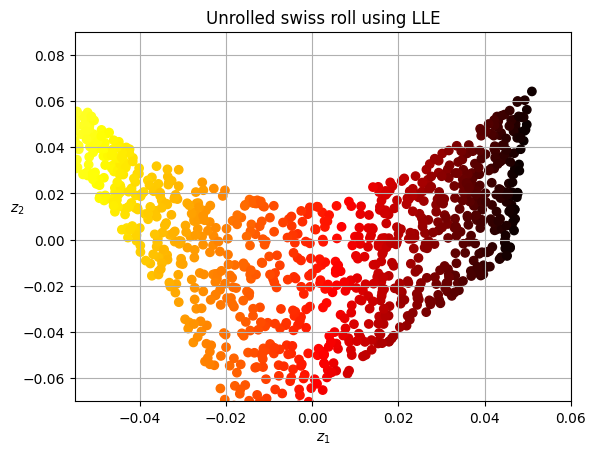

In [44]:
# Figure 8–10

plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

plt.title("Unrolled swiss roll using LLE")
plt.show()

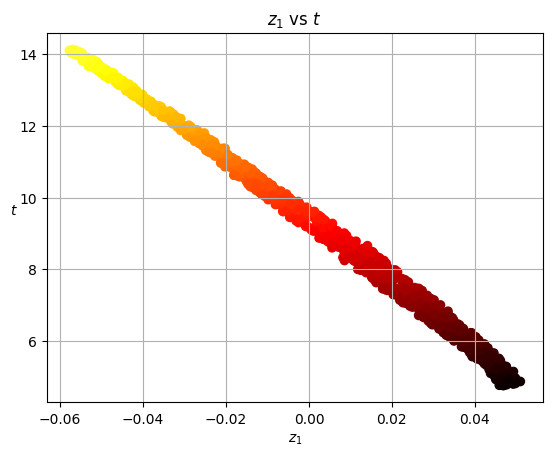

In [45]:
# shows how well correlated z1 is to t: LLE worked fine
plt.title("$z_1$ vs $t$")
plt.scatter(X_unrolled[:, 0], t, c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$t$", rotation=0)
plt.grid(True)
plt.show()

Note: I added `normalized_stress=False` below to avoid a warning about the fact that the default value for that hyperparameter will change in the future. Please see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html) for more details.

> LLE is an excellent tool for exploring nonlinear structures in data. While it's slower than PCA or random projection, the quality of embeddings is often far better when the manifold is twisted or curved. Just keep an eye on runtime and memory for larger datasets.

# Other Dimensionality Reduction Techniques

**1. MDS (Multidimensional Scaling)**

    Module: `sklearn.manifold.MDS`

    Goal: Preserve pairwise distances between points.

    Best for: Low-dimensional data where Euclidean distances matter.

    Pros: Captures global structure nicely.

    Cons: Can be slow and memory-intensive for large datasets.

Example Use Case: Visualizing customer similarities based on behavior metrics.

In [54]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, 
          normalized_stress=False, 
          random_state=42
)

X_reduced_mds = mds.fit_transform(X_swiss)

**2. Isomap (Isometric Mapping)**

    Module: `sklearn.manifold.Isomap`

    Goal: Preserve geodesic distances (shortest paths on a graph).

    Best for: Nonlinear data where you want to maintain global manifold structure.

    Pros: Great for unfolding shapes like the Swiss roll.

    Cons: Can struggle with noisy data or disconnected regions.

Example Use Case: Analyzing surface structure in 3D spatial data.

In [55]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X_swiss)

**3. t-SNE (t-distributed Stochastic Neighbor Embedding)**

    Module: `sklearn.manifold.TSNE`

    Goal: Keep similar points close, push dissimilar points apart.

    Best for: Visualizing high-dimensional clusters (e.g., MNIST).

    Pros: Excellent for spotting clusters and patterns.

    Cons: Not suitable for general-purpose dimensionality reduction; very slow and non-deterministic by default.

Example Use Case: Visualizing latent patterns in word embeddings or image data.

In [51]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2, 
    init="random", 
    learning_rate="auto",
    random_state=42
)

X_reduced_tsne = tsne.fit_transform(X_swiss)

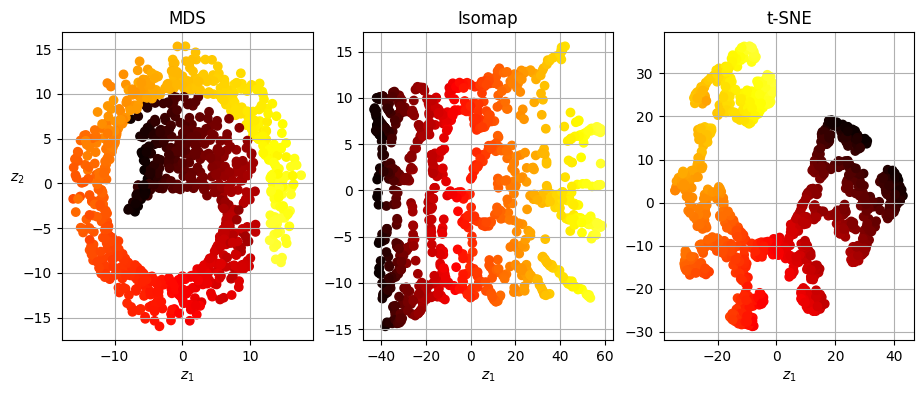

In [53]:
# Figure 8–11

titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11, 4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)

plt.show()

**4. LDA (Linear Discriminant Analysis)**

    Module: `sklearn.discriminant_analysis.LinearDiscriminantAnalysis`

    Goal: Maximize class separation using supervised learning.

    Best for: Reducing dimensionality before classification.

    Pros: Makes class boundaries more distinct.

    Cons: Requires labeled data; only works if classes are somewhat separable.

Example Use Case: Preprocessing for classification tasks like spam detection.

**Swiss Roll Comparison**

| Method     | Preserves           | Best For            | Notes                                           |
| ---------- | ------------------- | ------------------- | ----------------------------------------------- |
| **MDS**    | Euclidean distances | General structure   | May flatten but retain curvature                |
| **Isomap** | Geodesic distances  | Manifold unrolling  | Drops curvature but reveals shape               |
| **t-SNE**  | Local similarities  | Clustering          | Great for visualization, not for reconstruction |
| **LDA**    | Class separation    | Classification prep | Supervised; emphasizes discriminative axes      |

Each method has its niche:

    Use t-SNE for exploratory data visualization.

    Use LDA for supervised dimensionality reduction before classifiers.

    Use Isomap or MDS if you want to preserve global or manifold structure.

Choose based on your goal, data type, and scale.

# Extra Material – Kernel PCA

In [58]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(
    n_components=2, 
    kernel="rbf", 
    gamma=0.04, 
    random_state=42
)

X_reduced = rbf_pca.fit_transform(X_swiss)

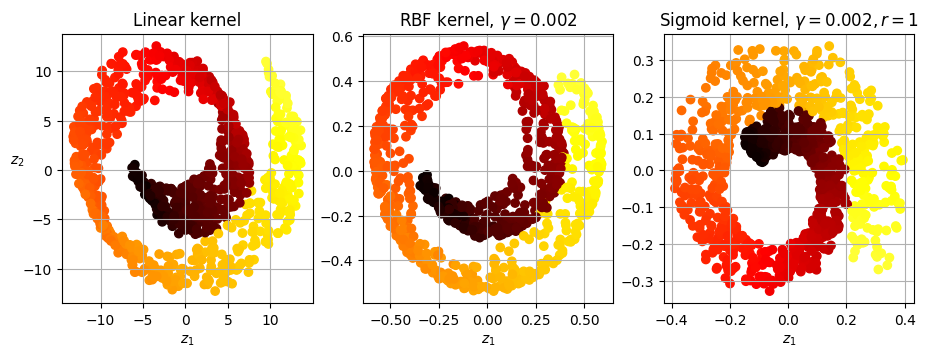

In [59]:
lin_pca = KernelPCA(kernel="linear")
rbf_pca = KernelPCA(kernel="rbf", gamma=0.002)
sig_pca = KernelPCA(kernel="sigmoid", gamma=0.002, coef0=1)

kernel_pcas = ((lin_pca, "Linear kernel"),
               (rbf_pca, rf"RBF kernel, $\gamma={rbf_pca.gamma}$"),
               (sig_pca, rf"Sigmoid kernel, $\gamma={sig_pca.gamma}, r={sig_pca.coef0}$"))

plt.figure(figsize=(11, 3.5))
for idx, (kpca, title) in enumerate(kernel_pcas):
    kpca.n_components = 2
    kpca.random_state = 42
    X_reduced = kpca.fit_transform(X_swiss)

    plt.subplot(1, 3, idx + 1)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if idx == 0:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid()

plt.show()